In [3]:
# Basic Imports 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Keras Imports 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

# sklearn imports
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
data_dir = '/kaggle/input/waste-classification-data/DATASET'
train_dir = os.path.join(data_dir, 'TRAIN')
validation_dir = os.path.join(data_dir, 'TEST')

In [5]:

train_datagen = ImageDataGenerator(
    rescale=1./255,        # normalize pixel values
    rotation_range=20,     # optional: data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255         # only rescale validation data
)

# Create data generators from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),  # resize all images
    batch_size=64,
    class_mode='binary',   # for binary classification
    color_mode='rgb'       # KEEP COLOR (do not convert to grayscale)
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='binary',
    color_mode='rgb'       # KEEP COLOR
)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


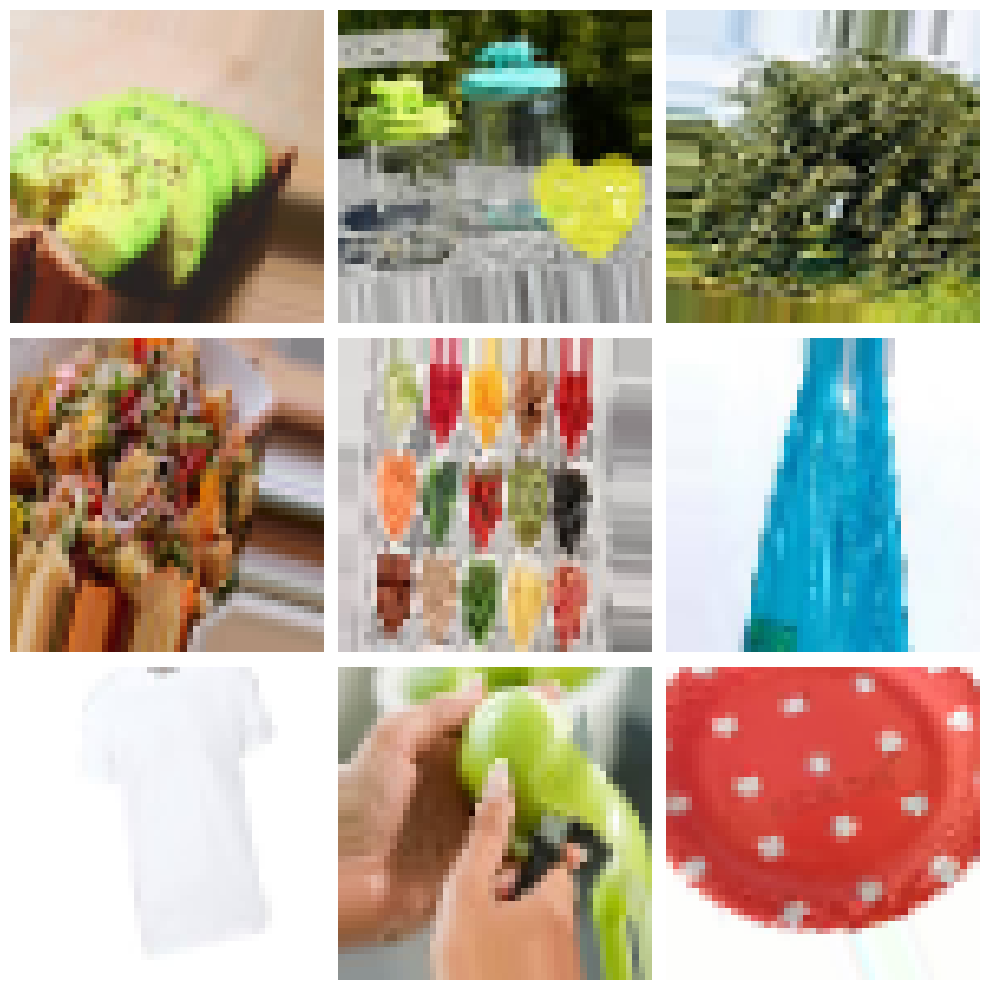

In [6]:
class_names = list(train_generator.class_indices.keys())

# Get a batch of images and labels
images, labels = next(train_generator)

# Plot 9 sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])  # no reshape, since images[i] is (48, 48, 3)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3)),  # use 3 for color images
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')  # ✅ Binary output
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',      # ✅ Binary loss
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1764080542.707239      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,472,833 (9.43 MB)

 Trainable params: 2,470,913 (9.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [8]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    "Wastebinary_model.h5",   
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)


lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler,checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1764080549.278387     124 service.cc:148] XLA service 0x78d39c007420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764080549.279056     124 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764080549.858297     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/353 ━━━━━━━━━━━━━━━━━━━━ 58:28 10s/step - accuracy: 0.5156 - loss: 0.9537

I0000 00:00:1764080554.497811     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.7614 - loss: 0.5981
Epoch 1: val_loss improved from inf to 0.42421, saving model to Wastebinary_model.h5
353/353 ━━━━━━━━━━━━━━━━━━━━ 152s 403ms/step - accuracy: 0.7614 - loss: 0.5978 - val_accuracy: 0.8631 - val_loss: 0.4242 - learning_rate: 0.0010
Epoch 2/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8186 - loss: 0.4190
Epoch 2: val_loss improved from 0.42421 to 0.40736, saving model to Wastebinary_model.h5
353/353 ━━━━━━━━━━━━━━━━━━━━ 59s 167ms/step - accuracy: 0.8186 - loss: 0.4190 - val_accuracy: 0.8130 - val_loss: 0.4074 - learning_rate: 0.0010
Epoch 3/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8286 - loss: 0.3917
Epoch 3: val_loss improved from 0.40736 to 0.38374, saving model to Wastebinary_model.h5
353/353 ━━━━━━━━━━━━━━━━━━━━ 58s 165ms/step - accuracy: 0.8286 - loss: 0.3917 - val_accuracy: 0.8583 - val_loss: 0.3837 - learning_rate: 0.0010
Epoch 4/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/st

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
              precision    recall  f1-score   support

           O       0.90      0.95      0.92        37
           R       0.92      0.85      0.88        27

    accuracy                           0.91        64
   macro avg       0.91      0.90      0.90        64
weighted avg       0.91      0.91      0.91        64



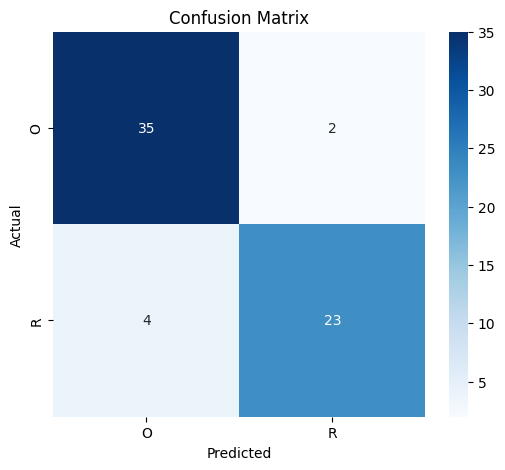

In [17]:
val_images, val_labels = next(validation_generator)

# Predict probabilities
predictions = model.predict(val_images)

# Convert probabilities to class labels (0 or 1)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = val_labels.astype(int) # already binary (0 or 1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

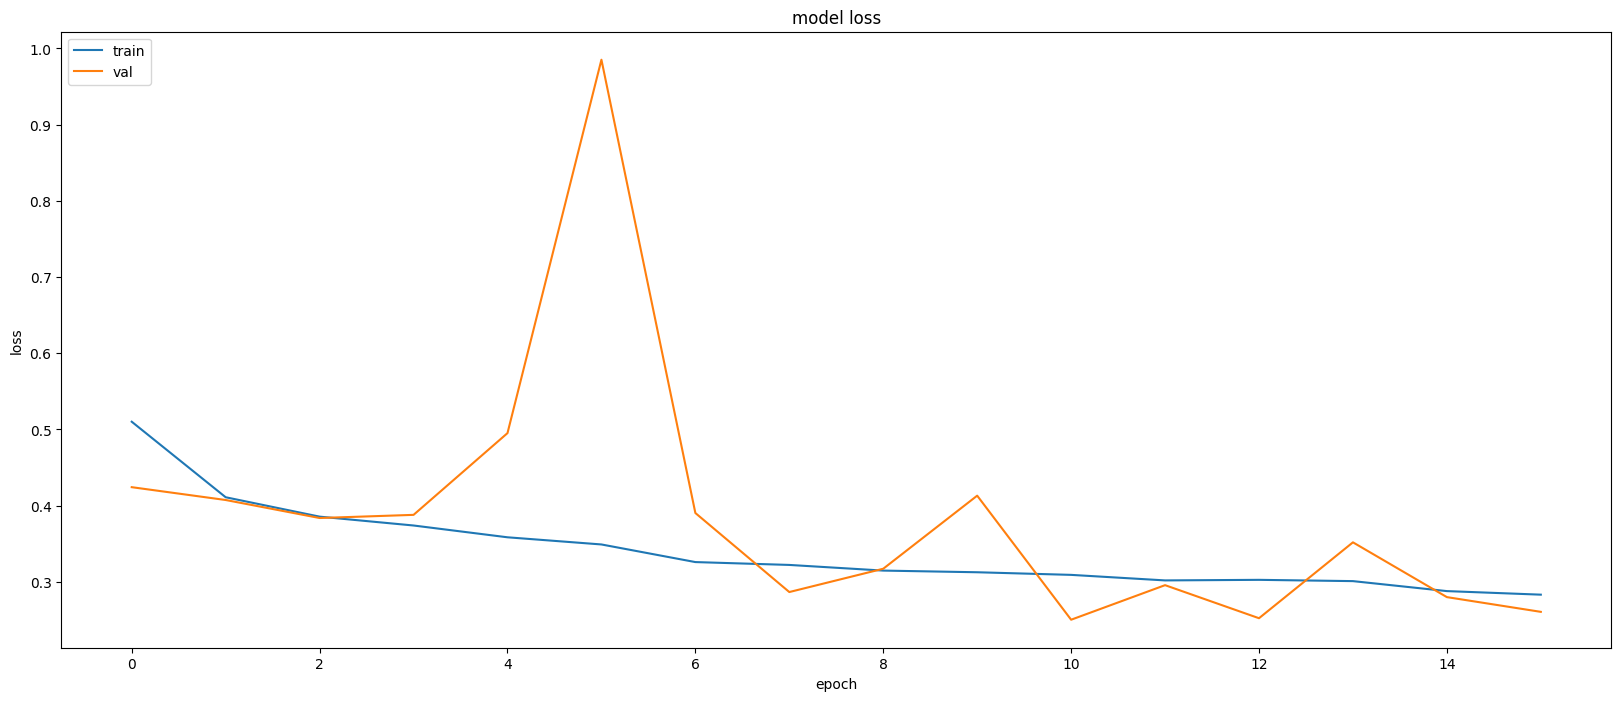

In [18]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


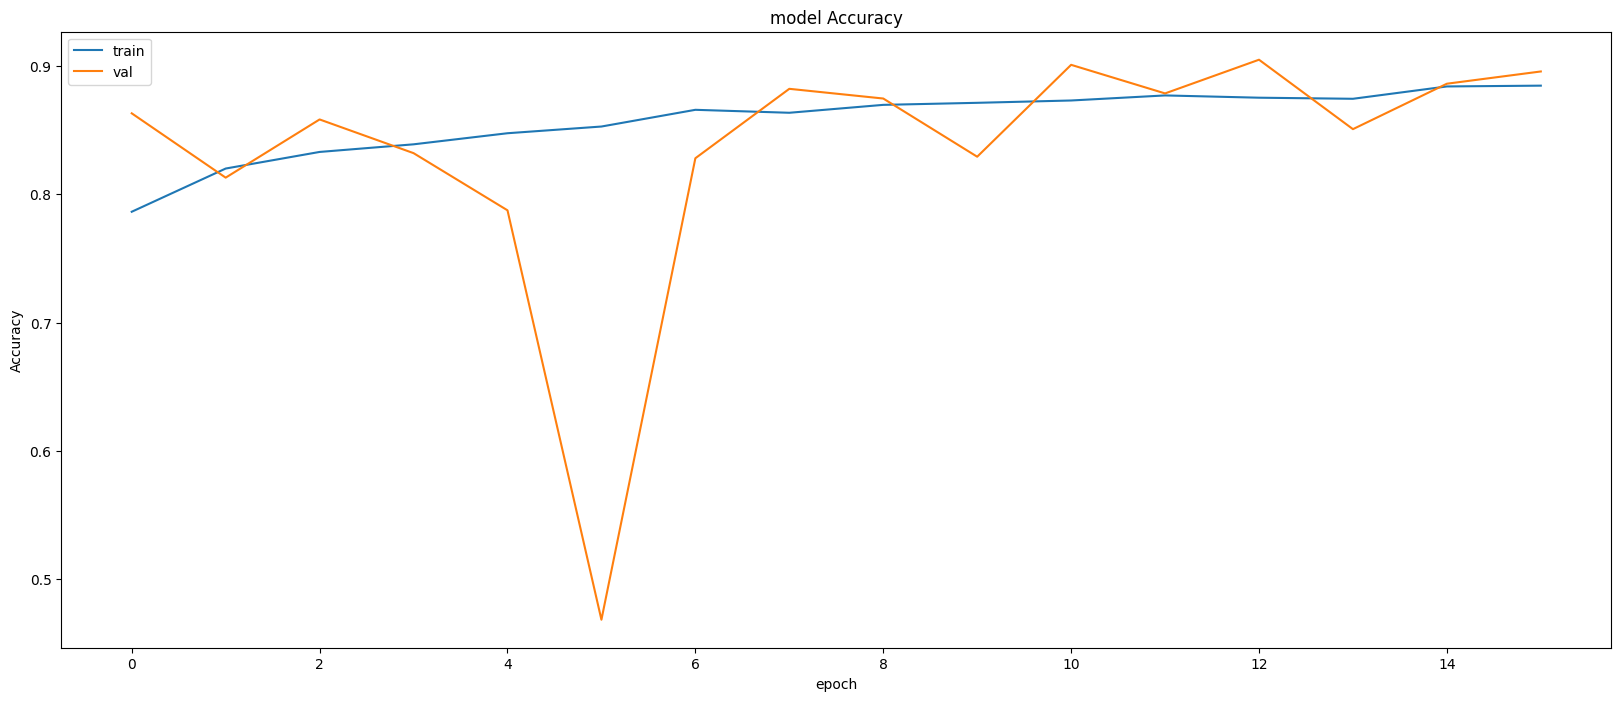

In [19]:

plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
